## Modules à importer

In [1]:
import math
import scipy
import pickle
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from variaIa import tools_ar
from variaIa.tools_ar import surveys, df_cons, df_nc, df_c, df_full
from importlib import reload
from scipy.stats import poisson
from variaIa import baserate
from variaIa import stretchevol
from astropy.cosmology import Planck15 as cdata
from IPython.display import display, Latex
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "EB Garamond",
})
    # "axes.labelsize": 'x-large',
    # "xtick.labelsize": 'x-large',
    # "ytick.labelsize": 'x-large'})
import random

## Define function

In [20]:
def show_results(data_, show_text=True, show_aicc=True,
                 show_span=True, redu=False, **kwargs):
    """ """
    if show_aicc:
        ykey = '$\Delta$ AIC'
        ylow = -35
        yscale = 'linear'
        shift = 0.95
    else:
        ykey = 'Proba'
        ylow = 1e-6
        yscale = 'log'
        shift = 1.5
    
    flag_fixed = np.asarray(data_["Fixed"], dtype="bool")
    flag_below = np.asarray(data_[ykey]<ylow, dtype="bool")
    if redu:
        prop = {**dict(marker="o", ms=10, ls="None", mew=2, zorder=8),**kwargs}
        prop_notfixed = dict(mfc="C1", mec="C1")
        prop_fixed = dict(mfc="w", mec="C1")
    else:
        prop = {**dict(marker="o", ms=10, ls="None", mew=2, zorder=8),**kwargs}
        prop_notfixed = dict(mfc="C0", mec="C0")
        prop_fixed = dict(mfc="w", mec="C0")
    # above Cut
    flag = ~flag_fixed*~flag_below
    if redu:
        ax.plot(data_.index[flag]-.07, data_[ykey][flag], **{**prop, **prop_notfixed})
    else:
        ax.plot(data_.index[flag]+.07, data_[ykey][flag], **{**prop, **prop_notfixed})
    flag = flag_fixed*~flag_below
    if redu:
        ax.plot(data_.index[flag]-.07, data_[ykey][flag],  **{**prop, **prop_fixed})
    else:
        ax.plot(data_.index[flag]+.07, data_[ykey][flag],  **{**prop, **prop_fixed})
    # Below Cut
    propbelow = {**prop, **{"marker":"v", "mew":1.5, "ms":8}}
    flag = ~flag_fixed*flag_below
    ax.plot(data_.index[flag], [ylow*shift]*len(data_.index[flag]), **{**propbelow, **prop_notfixed})
    flag = flag_fixed*flag_below
    ax.plot(data_.index[flag], [ylow*shift]*len(data_.index[flag]), **{**propbelow, **prop_fixed})
    flag = flag_below
    if show_text:
        for i in data_.index[flag]:
            ax.text(i, ylow*shift**2, "%.0f"%data_.iloc[i][ykey] if show_aicc else "%.1e"%data_.iloc[i][ykey], 
                    rotation=90, color="C0", va="bottom", ha="center", fontsize="small")
    #axt.plot(data.index, data["AICc"])
    ax.set_yscale(yscale)
    
    #if not show_aicc:
    #    for i in [1,2,3,4,5]:
    #        cut = stats.norm.pdf(i, loc=0, scale=1)*2
    #        ax.axhspan(1e-20, cut, color="C1", alpha=0.1)
    #        ax.text(xmax,cut,r"$%d\sigma$"%i,va="bottom", ha="right", color="C1")
    if show_span:
        spanprop = dict(alpha=.05, lw=.5)
        textprop = dict(va="bottom", ha="right")
        # Between 1 and 2 \sigma
        ax.axhspan(5, -5, color="tab:green", **spanprop)
        ax.text(xmax, -5, r"Acceptable", color="tab:green", **textprop)
        # Between 2 and 3 \sigma
        ax.axhspan(-5, -10, color="tab:gray", **spanprop)
        ax.text(xmax, -10, r"Défavorisé", color="tab:gray", **textprop)
        # Between 3 and 5 \sigma
        ax.axhspan(-10, -20, color="tab:orange", **spanprop)
        ax.text(xmax, -20, "Fortement\n défavorisé", color="tab:orange", **textprop)
        # Between 5 and lots of \sigma
        ax.axhspan(-20, ylow, color="tab:red", **spanprop)
        ax.text(xmax, ylow, r"Exclus", color="tab:red", **textprop)
        # 
        #if not show_aicc:
        #    ax.set_ylabel(r"Model Probability ($e^{0.5\Delta\mathrm{AIC}}$)")
        #else:
        #    ax.set_ylabel(r'$\Delta\mathrm{AIC}$')
    return(ylow)

## Comparison plot: supercut

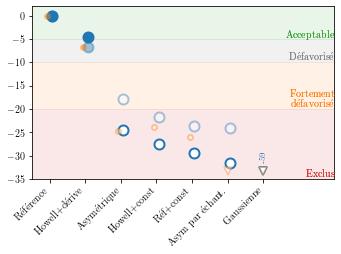

In [27]:
fig = plt.figure(figsize=[6,4])
ax = fig.add_axes([0.15,0.3,0.7,0.6])
xmax = 8

d_mod_comp_py   = pd.read_csv('../../../Data/tables/main_comp/df_comparaison_fr.dat')
d_mod_comp_cons   = pd.read_csv('../../../Data/tables/main_comp/df_comparaison_cons_fr.dat')
d_mod_comp_scons = pd.read_csv('../../../Data/tables/main_comp/df_comparaison_cons-supercut.dat')

ylow = show_results(d_mod_comp_py)
ylow = show_results(d_mod_comp_cons, alpha=.4, show_text=False)
ylow = show_results(d_mod_comp_scons, alpha=.4,
                    redu=True,
                    show_text=False, show_span=False,
                    **dict(ms=5))

ax.set_xticks(d_mod_comp_py.index)
ax.set_xticklabels([d_mod_comp_py.iloc[i]["Name"] for i in d_mod_comp_py.index], rotation=45, 
                   fontdict=dict(ha="right"))

ax.set_ylim(ylow, 2)
ax.set_xlim(-0.5, xmax)

fig.savefig('../../../Images/pdf/mod_comp-supercut.pdf', bbox_inches='tight')
fig.savefig('../../../Images/png/mod_comp-supercut.png', bbox_inches='tight', dpi=600)

### Without HST

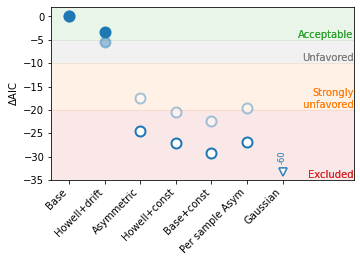

In [4]:
fig = plt.figure(figsize=[6,4])
ax = fig.add_axes([0.15,0.3,0.7,0.6])
xmax = 8

d_mod_comp_py   = pd.read_csv('../../../Data/tables/main_comp/df_comparaison-nHST.dat')
d_mod_comp_cons = pd.read_csv('../../../Data/tables/main_comp/df_comparaison-nHST_cons.dat')
ylow = show_results(d_mod_comp_py)
ylow = show_results(d_mod_comp_cons, alpha=.4, show_text=False)

ax.set_xticks(d_mod_comp_py.index)
ax.set_xticklabels([d_mod_comp_py.iloc[i]["Name"] for i in d_mod_comp_py.index], rotation=45, 
                   fontdict=dict(ha="right"))

ax.set_ylim(ylow, 2)
ax.set_xlim(-0.5, xmax)

fig.savefig('../../../Images/pdf/mod_comp-nHST.pdf', bbox_inches='tight')
fig.savefig('../../../Images/png/mod_comp-nHST.png', bbox_inches='tight', dpi=600)

### Main

(-0.5, 8.0)

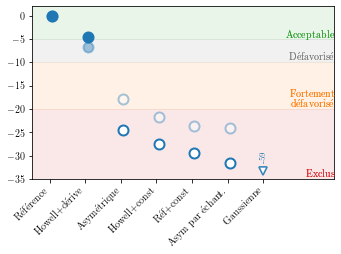

In [28]:
fig = plt.figure(figsize=[6,4])
ax = fig.add_axes([0.15,0.3,0.7,0.6])
xmax = 8

d_mod_comp_py   = pd.read_csv('../../../Data/tables/main_comp/df_comparaison_fr.dat')
d_mod_comp_cons = pd.read_csv('../../../Data/tables/main_comp/df_comparaison_cons_fr.dat')


ylow = show_results(d_mod_comp_py, alpha=1)
ylow = show_results(d_mod_comp_cons, alpha=.4, show_text=False)

ax.set_xticks(d_mod_comp_py.index)
ax.set_xticklabels([d_mod_comp_py.iloc[i]["Name"] for i in d_mod_comp_py.index], rotation=45, 
                   fontdict=dict(ha="right"))

ax.set_ylim(ylow, 2)
ax.set_xlim(-0.5, xmax)

# fig.savefig('../../../Images/pdf/mod_comp-nocons.pdf', bbox_inches='tight')
# fig.savefig('../../../Images/png/mod_comp-nocons.png', bbox_inches='tight', dpi=600)
# fig.savefig('../../../Images/pdf/mod_comp-fr.pdf', bbox_inches='tight')
# fig.savefig('../../../Images/png/mod_comp-fr.png', bbox_inches='tight', dpi=600)

## For ZTF

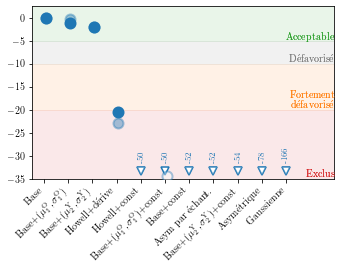

In [36]:
fig = plt.figure(figsize=[6, 4])
ax = fig.add_axes([0.15, 0.3, 0.7, 0.6])
xmax = 12

d_mod_comp_py = pd.read_csv('../../../Data/tables/main_comp/df_comparaison_all-ztf.dat')
d_mod_comp_cons = pd.read_csv('../../../Data/tables/main_comp/df_comparaison_cons_all-ztf.dat')

ylow = show_results(d_mod_comp_py)
ylow = show_results(d_mod_comp_cons, alpha=.4, show_text=False)

ax.set_xticks(d_mod_comp_py.index)
ax.set_xticklabels([d_mod_comp_py.iloc[i]["Name"] for i in d_mod_comp_py.index], rotation=45, 
                   fontdict=dict(ha="right"))

ax.set_ylim(ylow, 2.5)
ax.set_xlim(-0.5, xmax)

fig.savefig('../../../Images/pdf/mod_comp_ztf-fr.pdf', bbox_inches='tight')
fig.savefig('../../../Images/png/mod_comp_ztf-fr.png', bbox_inches='tight', dpi=600)

## With _z-only_

(-0.5, 8.0)

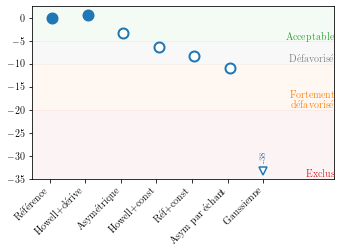

In [30]:
fig = plt.figure(figsize=[6,4])
ax = fig.add_axes([0.15,0.3,0.7,0.6])
xmax = 8

d_mod_comp_py = pd.read_csv('../../../Data/tables/main_comp/df_comparaison_zonly_fr.dat')
d_mod_comp_cons = pd.read_csv('../../../Data/tables/main_comp/df_comparaison_zonly_cons_fr.dat')

ylow = show_results(d_mod_comp_py)
#ylow = show_results(d_mod_comp_cons, alpha=.4, show_text=False)

ax.set_xticks(d_mod_comp_py.index)
ax.set_xticklabels([d_mod_comp_py.iloc[i]["Name"] for i in d_mod_comp_py.index], rotation=45, 
                   fontdict=dict(ha="right"))

ax.set_ylim(ylow, 2.5)
ax.set_xlim(-0.5, xmax)

# fig.savefig('../../../Images/pdf/mod_comp_zonly-fr.pdf', bbox_inches='tight')
# fig.savefig('../../../Images/png/mod_comp_zonly-fr.png', bbox_inches='tight', dpi=600)

## Comparison plot with conservative-sized samples

In [34]:
DAIC_4mod = [d_mod_comp_4mod[i][d_mod_comp_4mod[i]['Name'] == 'Base+const']['$\Delta$ AIC'].values[0]
             for i in range(200)]

In [41]:
np.sort(DAIC_4mod)[::-1]

array([1242. ,  -23.7,  -23.8,  -24.5,  -25. ,  -25.3,  -25.4,  -25.5,
        -25.6,  -25.6,  -25.7,  -26. ,  -26. ,  -26.2,  -26.2,  -26.3,
        -26.3,  -26.3,  -26.5,  -26.6,  -26.6,  -26.7,  -26.7,  -26.8,
        -26.8,  -26.8,  -26.9,  -26.9,  -27. ,  -27. ,  -27.1,  -27.2,
        -27.2,  -27.2,  -27.3,  -27.3,  -27.3,  -27.3,  -27.3,  -27.3,
        -27.3,  -27.4,  -27.4,  -27.5,  -27.5,  -27.6,  -27.6,  -27.6,
        -27.7,  -27.8,  -27.8,  -27.8,  -27.8,  -27.9,  -27.9,  -27.9,
        -27.9,  -27.9,  -27.9,  -28. ,  -28. ,  -28. ,  -28. ,  -28.1,
        -28.1,  -28.2,  -28.2,  -28.2,  -28.2,  -28.2,  -28.3,  -28.3,
        -28.3,  -28.3,  -28.3,  -28.4,  -28.4,  -28.4,  -28.4,  -28.4,
        -28.4,  -28.5,  -28.5,  -28.6,  -28.6,  -28.6,  -28.6,  -28.6,
        -28.6,  -28.6,  -28.7,  -28.7,  -28.7,  -28.7,  -28.7,  -28.7,
        -28.8,  -28.8,  -28.8,  -28.8,  -28.8,  -28.9,  -28.9,  -28.9,
        -28.9,  -28.9,  -28.9,  -28.9,  -29. ,  -29. ,  -29. ,  -29. ,
      

(-0.5, 6.0)

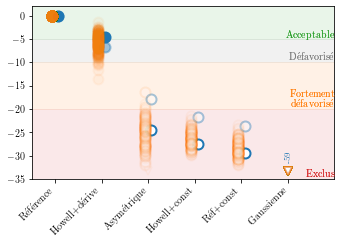

In [31]:
fig = plt.figure(figsize=[6,4])
ax = fig.add_axes([0.15,0.3,0.7,0.6])
xmax = 6

d_mod_comp_4modfidu = pd.read_csv('../../../Data/tables/main_comp/df_comparaison_6mod.dat')
d_mod_comp_4modcons = pd.read_csv('../../../Data/tables/main_comp/df_comparaison_6mod_cons.dat')
d_mod_comp_4mod = [pd.read_csv(f'../../../Data/tables/main_comp/df_comparaison_6mod_{i}.dat')
                   for i in range(200)]

ylow = show_results(d_mod_comp_4modfidu)
ylow = show_results(d_mod_comp_4modcons, alpha=.4,
                    show_text=False, show_span=True)
for i in range(200):
    show_results(d_mod_comp_4mod[i], alpha=.05, redu=True,
                 show_text=False, show_span=False)

ax.set_xticks(d_mod_comp_4modfidu.index)
ax.set_xticklabels([d_mod_comp_4modfidu.iloc[i]["Name"]
                    for i in d_mod_comp_4modfidu.index],
                   rotation=45, 
                   fontdict=dict(ha="right"))

ax.set_ylim(ylow, 2)
ax.set_xlim(-0.5, xmax)

# fig.savefig('../../../Images/pdf/mod_comp_6mod.pdf', bbox_inches='tight')
# fig.savefig('../../../Images/png/mod_comp_6mod.png', bbox_inches='tight', dpi=600)

## Définitions pandas, surveys et sélection de l'échantillon à utiliser

In [14]:
def set_survey(cons, su):
    global df
    if su == 'All':
        df = df_cons(cons)
    elif 'n' in su:
        df = df_cons(cons)[df_cons(cons)['survey'] != su.split('n')[-1]]
    else:
        df = df_cons(cons)[df_cons(cons)['survey'] == su]
    return df

int_set_su = ipw.interactive(set_survey, cons=tools.cons, su=tools.su)
display(int_set_su)

smap = plt.cm.get_cmap('cividis')
colors = {'SNF': plt.cm.binary(0.9),
          'SDSS': smap(0.1),
          'PS1': smap(0.5),
          'SNLS': smap(0.8),
          'HST': smap(0.99),  # for cividis
          #'HST': smap(300)}  # for viridis
          'All': (255/255, 51/255, 0/255)} 

alphacolors = {'1': {survey:
                     (colors[survey][0], colors[survey][1], colors[survey][2], .1)
                     for survey in surveys},
               '3': {survey:
                     (colors[survey][0], colors[survey][1], colors[survey][2], .3)
                     for survey in surveys},
               '5': {survey:
                     (colors[survey][0], colors[survey][1], colors[survey][2], .5)
                     for survey in surveys},
               '8': {survey:
                     (colors[survey][0], colors[survey][1], colors[survey][2], .8)
                     for survey in surveys}} 

df_nHST = df_nc[df_nc['survey'] != 'HST']

interactive(children=(Checkbox(value=False, description='Conservative'), Dropdown(description='Survey:', index…

# Individual model plots

(-3.2, 3.2)

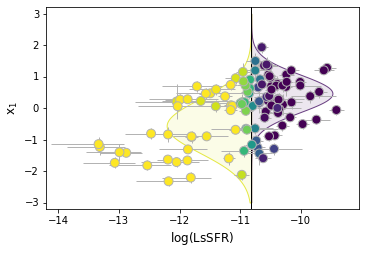

In [9]:
gen.set_model('Evol2G2M2S')
gen.set_data(df)
how = gen.fit()

fig = plt.figure(figsize=[7, 3.5])
ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])

how.scatter(ax=ax, mod_lw=1, elw=1, lw=1,
            facealpha=1, show_leg=False)

ax.set_xlim(-14.2, -9.05)
ax.set_ylim(-3.2, 3.2)

fig.savefig('../../../../Images/model_howell.pdf', bbox_inches='tight')

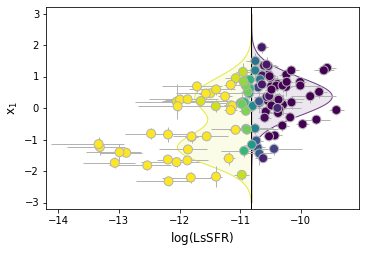

In [17]:
gen.set_model('Evol3G2M2S')
gen.set_data(df)
base = gen.fit()

fig = plt.figure(figsize=[7, 3.5])
ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])

base.scatter(ax=ax, mod_lw=1, elw=1, lw=1,
            facealpha=1, show_leg=False)

ax.set_xlim(-14.2, -9.05)
ax.set_ylim(-3.2, 3.2)

fig.savefig('../../../../Images/model_base.pdf', bbox_inches='tight')

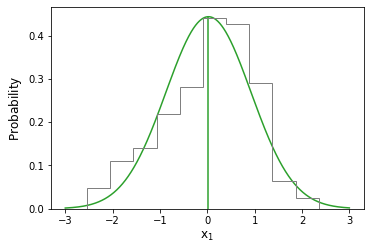

In [16]:
gen.set_model('Evol1G1M1S')
gen.set_data(df)
gauss = gen.fit()

fig = plt.figure(figsize=[7, 3.5])
ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])

gauss.show_model_tot(ax=ax)
fig.savefig('../../../../Images/model_gauss.pdf', bbox_inches='tight')

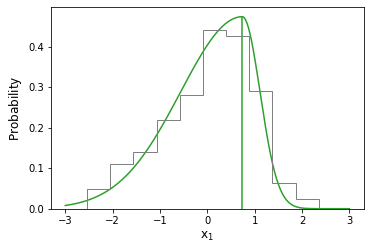

In [20]:
gen.set_model('Evol1G1M2S')
gen.set_data(df)
asymm = gen.fit()

fig = plt.figure(figsize=[7, 3.5])
ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])

asymm.show_model_tot(ax=ax)
fig.savefig('../../../../Images/model_asymm.pdf', bbox_inches='tight')